## Week 4 Day 4 - preparing the big project!

# The Sidekick

It's time to introduce:

1. Structured Outputs
2. A multi-agent flow

In [1]:
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from IPython.display import Image, display
import gradio as gr
import uuid
from dotenv import load_dotenv

In [2]:
# load_dotenv(override=True)
load_dotenv("/Users/alex/Desktop/00_projects/AI_agents/my_agents/.env", override=True)

True

### For structured outputs, we define a Pydantic object for the Schema

And you'll remember the first step of Structured Outputs is to define the schema. What are we using to describe the results that must come back from an LLM? And in particular, the thing that we're going to be working on is an evaluator, something which is going to decide whether or not an answer from an LLM is good. And so our evaluator is going to respond using this object, an evaluator output. Or really, it's going to respond with JSON, and the JSON is going to have to conform to this. So we just describe what this means. There's going to be a field, Feedback, which is going to be feedback on the worker's response success criteria. Actually, let's change this to the assistance response, because that's going to be more words that it will understand. Worker is what we will call it in this assistance response. There we go. Now you get see-me type. So feedback on the assistance response success criteria is whether the success criteria has been met. And user input needed. True if more input is needed from the user, or clarifications, or if the assistant is stuck. So this is going to allow, we're going to have an evaluator. It's going to evaluate the results of our worker, the assistant, to use that terminology. And it's going to decide whether it's okay to forward that back to the user, or whether it needs to go back to the assistant for more work. And one situation is if the success criteria are met and it's done its job, but another situation is if the worker seems to be stuck or needs clarifications, in which case it should return.

In [3]:
# First define a structured output

class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")


### And for the State, we'll use TypedDict again

But now we have some real information to maintain!

The messages uses the reducer. The others are simply values that we overwrite with any state change.

---
And now, to manage state. You remember with state, it can really be any Python object. It can be a Pydantic object, but we often use type Dix, and that's what we're doing here. And now, for the first time, we have some real meaty information to store in the state. We've always had messages before, but now we have a real state. And we've got a bunch of things. We do still have messages, which is representing the discussion between the user and the assistant. But we've got other stuff, which is going to represent the information being passed from the evaluator back to the thing I'm going to call the worker, the assistant. And so we're going to have some more stuff. We're going to have success criteria, which is going to be set up front to define what does it mean to be successful. Feedback on the work, that's going to come from the worker. And by the way, you use optional like this. If this can be null, it can be none, or it can be a string. Success criteria met is a bull is true or false, and it's going to be true if there has been a successful outcome, that the criteria are met and it doesn't need to go back to the worker for more. And user input needed is if we need to go back to the user to get some more information. So that is our state. So it's a much meatier state, and this shows you that you can have whatever you want in the state. The state is really up to you and the flow of your logic. And that state is like something that is moved through the graph, and everyone gets their opportunity. Every node gets the state and gets its opportunity to return a new state that is some change to that state. And we're only specifying one reducer, add messages, which means that if one of these nodes returns with some messages, they will get accumulated, they will get concatenated with the existing messages. But if one of these nodes returns user input needed, that will overwrite whatever was in the old state. So when you return the new state, if you change one of these values here, that becomes the new setting for anything that is downstream of you in the graph. 

In [4]:
# The state

class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

Okay, so next up we set up our playwright tools. This is the same code as before, using the async browser, the playwright browser, and the playwright browser toolkit. So we just run that, that's pretty simple. 

In [5]:
# Get our async Playwright tools

import nest_asyncio
nest_asyncio.apply()
async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

And now we're going to have two LLMs that we're going to initialize. One of them is called the worker LLM, it plays the role of the assistant. It's going to be a GPT-40 mini, and it's going to be bound to those tools, so that it will automatically have the JSON gumph in it. And then separately we're going to have an evaluator LLM. This is a separate LLM, and it is, we're setting it up, whereas before we said bind tools, and now we say with structured output, and pass in the pedantic object, and that means that the response will conform to this output. Now not all models are set up to support structured output, so you may find that some models can't do it, if you're going to be playing around with different models. If that is the case, of course the alternative to this is to do it the old-fashioned way, which means instead of using structured outputs like this and passing a pedantic object, you ask the model in the prompt to respond in JSON. You give it the schema, you list out what kind of JSON it should respond in, you maybe give a couple of examples to make sure that it's really biased to do well, and then you have to parse that JSON in the response. And that's all that is happening behind the scenes when we do structured outputs like this. 

In [6]:
# Initialize the LLMs

worker_llm = ChatOpenAI(model="gpt-4o-mini")
worker_llm_with_tools = worker_llm.bind_tools(tools)

evaluator_llm = ChatOpenAI(model="gpt-4o-mini")
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

Okay, so this is a bit of a long-looking method function, this node, the depth worker, which is representing our worker node, our assistant, but it's only long because we've got a lot of prompting in here. So, it's a node, and so, as usual, it takes a state, and it's going to return a state. And you can see it's returning something with messages, and we know that messages accumulate because we have the reducer, so that is going to add on more messages. 

Okay, so we've got a long system message, let me talk you through it. We say, look, you're a helpful assistant that can use tools to complete tasks. You keep working on a task until either you have a question or clarification for the user, or the success criteria has been met. And this is the success criteria, and we take it from the state, something that should be held in the `state`. You should reply, either with a question for the user about the assignment, or with your final response. If you have a question for the user, you need to reply by clearly stating your question. An example might be this. That's not super necessary for me to have done that, but I wanted to make it really clear that it was a say or an answer question, and sort of force the point. If you've finished, reply with the final answer, and don't ask a question, simply reply with the answer. And I say that because these models love to reply with things like, can I help you with anything else? And that then might confuse our evaluator that's looking to see if it needs help, so I want it to be super clear on this front. Okay.

Okay, and of course all these things are subject for experimentation. There's no hard and fast rules. It's not like that is a rule that you have to put this in the prompt. I hope you know this by now. This is really the part of AI engineering that is about experimentation, R&D. You can imagine I've been crafting this prompt for the last couple of hours. So it's something that obviously you hone in on something that works well, and you may find that particularly with different models or if you have different assignments, it's something that you have to tweak to get the kind of performance you want. Anyways, if we've got in our state and met something in this field, feedback on work, then that means that an evaluation has happened and it's not gone well, there's been feedback, and it's come back for more. 

So then we add to the system message, previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met. Here is the feedback on why this was rejected, and then we give the feedback. And then with this feedback, please continue the assignment, ensuring you meet the success criteria. So there it is spelled out in detail. Okay, and then I've got here some slightly hokey code that looks to see whether there's already a system message inside there, and if there already is, then it just replaces whatever system message is there with this system message. If it doesn't find a system message, then it creates a new one and puts it up the front. So this is just to make sure that we handle those various scenarios. And this is a little bit hokey because Langerup will have already perhaps built a system message, so we have to be a bit careful about this. It might be worth doing some testing to make sure that it works for different models. Okay, so at the end of all that, we then call worker llm with tools, and we invoke the messages. We get back a response, and that is what we then return. So there we have it.

In [7]:
# The worker node

def worker(state: State) -> Dict[str, Any]:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
This is the success criteria:
{state['success_criteria']}
You should reply either with a question for the user about this assignment, or with your final response.
If you have a question for the user, you need to reply by clearly stating your question. An example might be:

Question: please clarify whether you want a summary or a detailed answer

If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.
"""
    
    if state.get("feedback_on_work"):
        system_message += f"""
Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
Here is the feedback on why this was rejected:
{state['feedback_on_work']}
With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    
    # Add in the system message

    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invoke the LLM with tools
    response = worker_llm_with_tools.invoke(messages)
    
    # Return updated state
    return {
        "messages": [response],
    }

worker_router 

The worker router then, it's a Python function that we will use in our edge, in our conditional edge, to decide which way to route control. And it's very simple, it's going to take the most recent message, it's going to see if it's a tool call, if so it returns tools, if not evaluator. And that is to say that when our worker, our assistant, has come up with an answer, if it's not involving a tool call, then it needs to be evaluated. 


In [8]:
def worker_router(state: State) -> str:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "evaluator"

format_conversation

And that's what we get to right now. So for the evaluation, we have, first of all, this little utility function format conversation, that's just used to take in, I just wrote that to transform a list of these message objects into something which says like user assistant, user assistant, into a nice little text summary. And you'll see right now, as we come on to look at the evaluator code, run these two cells, and we will talk about the evaluator. 

In [9]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

So this is the `evaluator`, this function right here, it is a node, it takes a state and it returns a state, and it's meant to represent the LLM, which is going to be assessing our assistant, our worker, and deciding if it's ready to return to the user, or it needs to go back for more. And so it all comes down to some prompting, and let me take you through it. Remember that we're using structured outputs that will require that the model returns a particular type of object. So first we take the most recent response, which is of course the assistant's attempt. We take that out of the state object, the messages collection. So then we come up with this system prompt. You are an evaluator. Determine if a task has been completed successfully by an assistant. Assess the last response based on the criteria. Respond with your feedback and a decision on whether the success criteria is met, and whether more input is needed from the user. And then the user message, this is going to be a bit more detailed, you're evaluating a conversation between the user and the assistant. You decide what action to take based on the last response from the assistant. The entire conversation with the assistant, along with the user's original request and all replies, is here. And this is going to use this little utility thing, which is just going to say like human, sorry not human, it's going to say user assistant, user assistant, with the whole conversation so far. So it's going to look very simple in language. The success criteria for this assignment is, and then I'm plucking out of the state, this success criteria. And as I hope you guessed, this is something that's going to be set right at the very beginning when we invoke the graph. So that's going to be passed in by the user and be maintained throughout the graph. So we can pluck it out and just insert it in the user prompt for this evaluator right here. And then I say the final response from the assistant that you were evaluating is this last response. And of course that will already be included in here, but I just want to be crystal clear so that the evaluator understands that it's not assessing the whole conversation, it's just assessing this response right here, which is what's going back to the user. Respond with your feedback and decide if the success criteria is met. Also if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help. 


So you may remember that we already put some of this in the definition of the structured outputs of the response right up at the top. Let me show you that. Right here in the evaluator output, we already gave a little description of user input needed right here. 

```py
# First define a structured output
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")
```

And so you may wonder why I'm repeating myself here. And the answer is because there's never a harm in being repetitious with prompting. Be clear, be instructive, repeat yourself. These are good things to do in slightly different ways because it biases the model to doing what we want it to do. 

`if state["feedback_on_work"]`

Okay, and then finally, and here I put `if` we've already got some feedback in the `state object`, that means that the evaluator was already called in this very loop and has already provided feedback in the past. And so I add in, also note that in a prior attempt from the assistant, you provided this feedback. If you're seeing the assistant repeating the same mistakes, then consider responding that user input is required. Now you might think this is very clever. 

How did you come up with that? And why that? And when do I use this kind of thing? And look, the answer is there's no magic here. That is there because I was testing this and it kept messing up by the evaluators sending back the same problem again and again. And so this is the kind of thing that is trial and error. You experiment, you try, when something goes wrong, you change the prompt and you try some more. There's no magic and no clever rules to this. This won't always apply, but it applies here. And if you use a different model or slightly different tasks, you may find that you need to tweak this or use something different. And that is what AI engineering is all about. And that is what prompting is about. And so yeah, the answer is it's research and development. Okay, we'll finish this off in just a second.

`evaluator_messages`

We'll finish this off in just a sec. So we then put the system message and the user message, which is called a human message object, together into one list called evaluator messages. And it's confusing, because we're using this concept of system message and user message in order to talk to an evaluator. And this isn't actually a human message. It's actually something where it's a user prompt, but it's a message that we have manufactured. But that's just really how you go about building system and user prompts using LangChain's constructs. This is a LangChain construct within LangRuf. And so, you know, this is still achieving the same thing. All right. 

`eval_result`

Now, we then take our LLM, which is the evaluator LLM with structured outputs. We call invoke with these messages. And what comes back will be an instance of that class evaluator output. It is that pedantic object filled up. And behind the scenes, what's going on is that it's been asked to provide JSON, and that JSON has come back, and that JSON has been parsed into this object. That's how it did it. 

`new_state`

And so we're then going to create a new state, because we're meant to return a new state. And in that state, we're going to respond. We're going to add to the messages, because remember, messages has the reducer, so whatever we reply here gets concatenated, accumulated with the existing messages. We're going to shove in there that the assistant is replying, evaluates the feedback on this answer, and something in there. Then we're going to give some feedback. We're going to... And so what we're doing here is we're taking the feedback from the pedantic object, and we're putting that in the state. We're taking the success criteria from the pedantic object, putting it in the state. Taking user input needed, taking it from the pedantic, the structured outputs that came back, put it in the state, and return the new state. Hopefully you followed all that. If not, you will when it comes together.



In [10]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = f"""You are an evaluator that determines if a task has been completed successfully by an Assistant.
Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
and whether more input is needed from the user."""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

The entire conversation with the assistant, with the user's original request and all replies, is:
{format_conversation(state['messages'])}

The success criteria for this assignment is:
{state['success_criteria']}

And the final response from the Assistant that you are evaluating is:
{last_response}

Respond with your feedback, and decide if the success criteria is met by this response.
Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
"""
    if state["feedback_on_work"]:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    new_state = {
        "messages": [AIMessage(content=f"Evaluator Feedback on this answer: {eval_result.feedback}")],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state

And then we've got another of these router functions, root based on evaluation. If the success criteria is met, or if user input is needed, then end the super step. The super step is done, it's got to control, it's got to pass back to the user, in either of these two extremes. Either we've done great, or we've done horribly. Either of those extremes, we need the user to get involved again. But, but, if we didn't meet the success criteria, and we don't need help from the user, then it needs to be passed back to the worker. We need to cycle back, the worker's got to try again, and improve on this, given this feedback. That is the whole idea, that is the workflow. 

In [11]:
def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"

And now, we come to our graph. It's very simple, and all of this is pretty simple. I've been making a bit of a meal out of it, explaining this step by step, and talking about prompting, but it's not that hard. If you go through it yourself, you'll see what I mean. So, this is our graph. We're going to add our worker node, we're going to add our tools node, and our evaluator node that we just built. Now, some edges. We're going to have a conditional edge. For the worker, we're going to use the router that we wrote, the worker router. If it returns tools, we're going to go with the node tools. If it returns evaluator, we'll pick the node evaluator. We're going to add an edge that goes from tools back to worker again. Remember this one? When the tools finishes, it's got to route back to the worker. That's kind of hokey that you have to do that. You think it would be done automatically for you, but you have to be clear. And then, another conditional edge from the evaluator. Based on its evaluation, if it wants to go to the worker, we put it back to the worker. If we're done, we're done. And then, we also add a start edge to bring us, first of all, to the worker. Let's run that and look at a picture of this. There it is. There it is. We have ourselves a true agentic workflow. 

In [12]:
# Set up Graph Builder with State
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

# Add edges
graph_builder.add_conditional_edges("worker", worker_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"worker": "worker", "END": END})
graph_builder.add_edge(START, "worker")

# Compile the graph
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

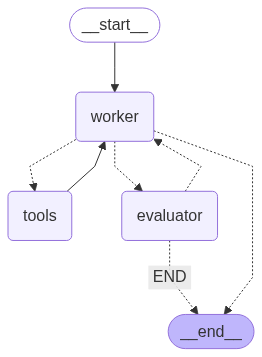

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

The start goes to a worker. That, optionally, can run tools, which has to come back. It's a thick line. Optionally, dotted line, an optional edge. A conditional edge is the word, sorry. It will run tool, and then it will definitely come back, an edge. And then, when it's done, this is shown as a conditional because it's only if it hasn't decided to run a tool. Then, it will come this way. And the evaluator chooses either to end. In two situations, either success criteria is met or user feedback is required. And, if not, it comes back to the worker. End or back to the worker. So, this diagram, hopefully, has everything coming together for you. And now, scroll back up in the lab and just take a look through those nodes again. And, at this point, it should be like, ah, got it, got it, got it, got it. And, hopefully, you'll see that, although I made a bit of a meal out of it, it is actually quite quick to build something like this. And you see one of Anthropic's agentic patterns loud and clear here. Although, it's a little bit more than one of their workflows because this has, like, an infinite loop in it. It can keep going, and there's a lot of optionality here. So, this is a true agent pattern because, in theory, this could just keep running and running. And it has some sort of agency autonomy over what it does. And, surely, you're now thinking, well, I want to see this thing. And that is what we will do next.

### Next comes the gradio Callback to kick off a super-step

Okay, so first of all, we have a callback, a Gradio callback that Gradio will call into when we press the button, which will kick off a super step. So I've got this little thing here, which is a cheeky thing that comes up with a thread ID, a random, big, unique number to make sure that each time that we bring up the interface, it's not going to continue the conversation from last time, or things can get quite hectic. So this means that every Gradio session is going to have a separate thread. This also means that we could actually run this and have multiple different people come on and use the interface and each have different conversations, which is really cool. 

So it's not just going to be for us, this sidekick. All right, so then the process message async, this coroutine, as I should call it, this function. So first of all, it creates a config based on the thread code that we're going to give it. Then it sets the initial state. So first of all, the initial state is going to take the user's message, the message that comes in. That's going to be the initial message. It's going to take the success criteria as the success criteria from the user that the user is going to tell us what they see as being needed for success. And this state will go through all of the graph and it will be used by the evaluator. The feedback on work, this is what the evaluator can set. Success criteria met, this is false to start with, user input needed, this is false to start with, and then here it is. Here we do it. We take a graph, we call a invoke, we pass in the state, the initial state, we pass in our config, and we wait for that to come back. With what comes back, we then need to build the stuff that's going to appear in the Gradio user interface. We package up the user's message. We package up the last two things that will have come back. The second last one will be the assistance reply, and the very last one is going to actually be the evaluator's evaluation, and we'll show them both coming so that they both appear in the UI. It'll be nice to see the evaluation as well, but you could remove this if you don't want to see the evaluation in the UI. And then we package that together in the history with all of this, and that's what we reply. There is a little bit of a confusion here, if you're following all this, that we're sort of combining Gradio's history with the history that's being stored in Landgraf's memory. It would probably be more elegant here to actually unpack the full history from the state, but that would start to get sort of messy, so I thought, keep it simple. This is fine. And then I've also got a little callback called reset that just resets the interface, so we'll just run this. 

In [14]:
def make_thread_id() -> str:
    return str(uuid.uuid4())


async def process_message(message, success_criteria, history, thread):

    config = {"configurable": {"thread_id": thread}}

    state = {
        "messages": message,
        "success_criteria": success_criteria,
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }
    result = await graph.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()



### And now launch our Sidekick UI



In [19]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success critiera?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

import asyncio
import nest_asyncio

nest_asyncio.apply()
try:
    asyncio.get_event_loop()
except RuntimeError:
    asyncio.set_event_loop(asyncio.new_event_loop())

    
demo.launch()


Exception in thread Thread-29 (run):
Traceback (most recent call last):
  File "/Users/alex/.local/share/uv/python/cpython-3.12.11-macos-x86_64-none/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/Users/alex/Desktop/00_projects/AI_agents/my_agents/agents_env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/Users/alex/.local/share/uv/python/cpython-3.12.11-macos-x86_64-none/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/alex/Desktop/00_projects/AI_agents/my_agents/agents_env/lib/python3.12/site-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/alex/Desktop/00_projects/AI_agents/my_agents/agents_env/lib/python3.12/site-packages/nest_asyncio.py", line 26, in run
    loop = asyncio.get_event_loop()
           ^^

KeyboardInterrupt: 

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/thanks.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00cc00;">Congratulations on making the first version of Sidekick!</h2>
            <span style="color:#00cc00;">This is a pretty epic moment in the course. You've made the start of something very powerful. And you've upskilled on an impressive Agent framework in LangGraph. Maybe like me you're being converted from a LangGraph skeptic to a LangGraph fan..<br/><br/>My editor would kill me if I didn't mention again: if you're able to rate the course on Udemy, I'd be so very grateful: it's the main way that Udemy decides whether to show the course to others and it makes a massive difference.<br/><br/>And another reminder that I love <a href="https://www.linkedin.com/in/eddonner/">connecting on LinkedIn</a> if you haven't yet! If you wanted to post about your progress on the course, please tag me and I'll weigh in to increase your exposure.
            </span>
        </td>
    </tr>